# SpaceNet Model - Classificação de Imagens Astronômicas usando CNNs e Optuna

Neste notebook, iremos treinar um modelo de aprendizado profundo utilizando `PyTorch` e `Optuna` para classificação de imagens astronômicas do dataset SpaceNet. O objetivo é otimizar os hiperparâmetros do modelo usando `Optuna` e avaliar a performance utilizando diversas métricas.

---

## 1. Configuração Inicial

In [1]:
from sklearn.metrics import classification_report, confusion_matrix
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, random_split
import optuna
import collections
import matplotlib.pyplot as plt
import seaborn as sns
from torchvision import datasets
import subprocess
import zipfile
import warnings
import os
import hashlib
from PIL import Image, UnidentifiedImageError
from concurrent.futures import ThreadPoolExecutor, as_completed
from tqdm import tqdm

# Desativar warnings para melhorar a visualização no notebook
warnings.filterwarnings("ignore")

# Ativar logs do Optuna em nível DEBUG
optuna.logging.set_verbosity(optuna.logging.DEBUG)
print("[INFO] Bibliotecas importadas com sucesso.")

[INFO] Bibliotecas importadas com sucesso.


C:\Users\cassi\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 2. Configuração do Dispositivo e Função de Pré-processamento

### 2.1 Configuraçao CUDA (SE DISPONÍVEL)

In [2]:
def get_max_threads():
    """Retorna o número máximo de threads que a CPU pode usar."""
    try:
        # Número de núcleos lógicos disponíveis (incluindo Hyper-Threading)
        max_threads = os.cpu_count() or 1  # Garantir pelo menos 1 thread
        print(f"[INFO] Número máximo de threads disponíveis: {max_threads}")
        return max_threads
    except Exception as e:
        print(f"[ERRO] Falha ao obter o número de threads: {e}")
        return 1

# Exemplo de uso
max_threads = get_max_threads()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if torch.cuda.is_available():
    print(f"[INFO] Usando o dispositivo: {torch.cuda.get_device_name(device)}")
else:
    print("[INFO] CUDA não está disponível. Usando CPU.")

[INFO] Número máximo de threads disponíveis: 24
[INFO] Usando o dispositivo: NVIDIA GeForce RTX 4060 Laptop GPU


### 2.2 Função para carregar imagens usando PIL


In [3]:
def pil_loader(path):
    try:
        with open(path, 'rb') as f:
            img = Image.open(f)
            img.load()  # Carregar a imagem completamente para verificar se está corrompida
            return img.convert('RGB')
    except (UnidentifiedImageError, OSError) as e:
        print(f"[ERRO] Não foi possível carregar a imagem: {path} - {e}")
        return None  # Retornar None se a imagem estiver corrompida

### 2.3 Função para verificar se o arquivo é uma imagem válida

In [4]:
def is_valid_file(filename):
    return filename.lower().endswith(('.jpg', '.jpeg', '.png'))

def is_image_valid(path):
    try:
        img = pil_loader(path)
        return img is not None
    except:
        return False

### 2.4 Classe para transformações


In [5]:
class TransformWithPrint:
    def __init__(self):
        self.transform = transforms.Compose([
            transforms.Resize((150, 150)),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])

    def __call__(self, img):
        return self.transform(img)

transform = TransformWithPrint()

## 3. Carregar o Dataset do Kaggle

Esta função baixa o dataset diretamente do Kaggle se ele não estiver presente localmente.


In [6]:
def download_dataset(dataset_path):
    print("[INFO] Iniciando o carregamento do dataset...")
    
    # Criar diretório se não existir
    os.makedirs(dataset_path, exist_ok=True)
    print(f"[INFO] Diretório '{dataset_path}' criado/verificado.")
    
    # Verificar se o diretório está vazio
    if not os.listdir(dataset_path):
        print("[INFO] Dataset não encontrado localmente. Realizando download...")

        # Utilizar subprocess para capturar a saída em tempo real
        result = subprocess.run(
            ["kaggle", "datasets", "download", "-d", "razaimam45/spacenet-an-optimally-distributed-astronomy-data", "-p", dataset_path],
            text=True, capture_output=True
        )

        # Mostrar a saída do comando
        print(result.stdout)
        if result.stderr:
            print("[ERRO]", result.stderr)
        
        zip_file_path = os.path.join(dataset_path, "spacenet-an-optimally-distributed-astronomy-data.zip")
        
        # Verificar se o arquivo zip foi baixado
        if os.path.exists(zip_file_path):
            print("[INFO] Extraindo o arquivo zip...")
            with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
                zip_ref.extractall(dataset_path)
            os.remove(zip_file_path)
            print("[INFO] Dataset extraído e arquivo zip removido.")
        else:
            print("[ERRO] Arquivo zip não encontrado após o download.")
    else:
        print("[INFO] Dataset já encontrado localmente.")

# Chamar a função para testar
dataset_path = "data/"
download_dataset(dataset_path)

[INFO] Iniciando o carregamento do dataset...
[INFO] Diretório 'data/' criado/verificado.
[INFO] Dataset já encontrado localmente.


## 4. Preparação e Processamento de Imagens
### 4.1 Função de Conversão para JPEG, Remoção de Duplicatas e PNG usando Processamento Paralelo
#### 4.1.1 Calcula o hash SHA-256 de uma imagem

In [7]:
def compute_image_hash(image_path):
    with open(image_path, 'rb') as f:
        return hashlib.sha256(f.read()).hexdigest()

#### 4.1.2 Converte uma imagem para o formato JPEG

In [8]:
def convert_to_jpeg(file_path, save_format="jpeg"):
    try:
        with open(file_path, 'rb') as f:
            img = Image.open(f).convert('RGB')
        new_file_path = f"{os.path.splitext(file_path)[0]}.{save_format}"
        img.save(new_file_path, save_format.upper())
        return new_file_path
    except (UnidentifiedImageError, IOError, OSError):
        print(f"[ERRO] Não foi possível carregar ou converter o arquivo: {file_path}")
        return None

#### 4.1.3 Remove imagens duplicadas no diretório com base no hash do conteúdo

In [9]:
def remove_duplicates(image_dir):
    print("[INFO] Verificando por duplicidades...")
    seen_hashes = {}
    files_to_remove = []
    def process_file(file_path):
        file_hash = compute_image_hash(file_path)
        if file_hash in seen_hashes:
            return file_path
        else:
            seen_hashes[file_hash] = file_path
        return None

    with ThreadPoolExecutor(max_workers=max_threads) as executor:
        futures = [executor.submit(process_file, os.path.join(root, file))
                   for root, _, files in os.walk(image_dir)
                   for file in files if file.lower().endswith('.jpeg')]
        
        for future in tqdm(as_completed(futures), total=len(futures), desc="Verificando duplicados", unit="arquivo"):
            result = future.result()
            if result:
                files_to_remove.append(result)

    for file_path in files_to_remove:
        print(f"[INFO] Removendo duplicado: {file_path}")
        os.remove(file_path)

#### 4.1.4 Verifica se todas as imagens restantes são arquivos JPEG.

In [10]:
def verify_all_jpeg(image_dir):
    print("[INFO] Verificando se todas as imagens são JPEG...")
    with ThreadPoolExecutor(max_workers=max_threads) as executor:
        def check_jpeg(file_path):
            if not file_path.lower().endswith('.jpeg'):
                print(f"[ERRO] Arquivo não é JPEG: {file_path}")

        futures = [executor.submit(check_jpeg, os.path.join(root, file))
                   for root, _, files in os.walk(image_dir)
                   for file in files]
        for future in tqdm(as_completed(futures), total=len(futures), desc="Verificando JPEG", unit="arquivo"):
            future.result()

#### 4.1.5 Converte todas as imagens para JPEG usando multi-threading.

In [11]:
def convert_images_parallel(dataset_path, delete_original=False):
    """Converte todas as imagens para JPEG usando processamento paralelo."""
    print(f"[INFO] Carregando e convertendo imagens no diretório: {dataset_path}")

    # Contar o número total de arquivos no diretório
    total_files = sum([len(files) for _, _, files in os.walk(dataset_path)])
    if total_files == 0:
        print("[INFO] Nenhuma imagem encontrada para conversão.")
        return

    # Função interna para converter a imagem e remover o arquivo original, se necessário
    def convert_and_remove(file_path):
        if file_path.lower().endswith((".jpg", ".jpeg", ".png")):
            new_file_path = convert_to_jpeg(file_path)
            
            # Se a conversão for bem-sucedida e delete_original for True, remover o arquivo original
            if new_file_path and file_path != new_file_path:
                if delete_original:
                    os.remove(file_path)
                    print(f"[INFO] Arquivo original removido: {file_path}")

    # Usar o número máximo de threads disponíveis no sistema
    max_threads = os.cpu_count()

    # Processar os arquivos em paralelo
    with ThreadPoolExecutor(max_workers=max_threads) as executor:
        futures = [executor.submit(convert_and_remove, os.path.join(root, file))
                   for root, _, files in os.walk(dataset_path)
                   for file in files]
        
        # Barra de progresso para monitorar o progresso da conversão
        for future in tqdm(as_completed(futures), total=total_files, desc="Convertendo Imagens", unit="imagem"):
            future.result()

    print("[INFO] Conversão de imagens concluída.")

# Exemplo de uso
dataset_path = "data/SpaceNet.FLARE.imam_alam"
convert_images_parallel(dataset_path, delete_original=True)

[INFO] Carregando e convertendo imagens no diretório: data/SpaceNet.FLARE.imam_alam


Convertendo Imagens:  26%|██▋       | 2890/10906 [00:09<00:30, 263.75imagem/s]

[ERRO] Não foi possível carregar ou converter o arquivo: data/SpaceNet.FLARE.imam_alam\constellation\constellation_page_9_image_7_3_SwinIR_large.jpeg[ERRO] Não foi possível carregar ou converter o arquivo: data/SpaceNet.FLARE.imam_alam\constellation\constellation_page_9_image_7_2_SwinIR_large.jpeg

[ERRO] Não foi possível carregar ou converter o arquivo: data/SpaceNet.FLARE.imam_alam\constellation\constellation_page_9_image_7_4_SwinIR_large.jpeg


Convertendo Imagens:  28%|██▊       | 3027/10906 [00:09<00:32, 245.51imagem/s]

[ERRO] Não foi possível carregar ou converter o arquivo: data/SpaceNet.FLARE.imam_alam\constellation\constellation_page_9_image_7_aug3_SwinIR_large.jpeg


Convertendo Imagens: 100%|██████████| 10906/10906 [00:38<00:00, 283.60imagem/s]

[INFO] Conversão de imagens concluída.


#### 4.1.6 Remove todos os arquivos PNG restantes após a conversão

In [12]:
def delete_remaining_png_files(dataset_path):
    """Remove todos os arquivos PNG restantes após a conversão."""
    print("[INFO] Removendo todos os arquivos PNG restantes...")
    with ThreadPoolExecutor(max_workers=max_threads) as executor:
        futures = [executor.submit(os.remove, os.path.join(root, file))
                   for root, _, files in os.walk(dataset_path)
                   for file in files if file.lower().endswith('.png')]
        
        for future in tqdm(as_completed(futures), total=len(futures), desc="Removendo PNG", unit="arquivo"):
            future.result()

#### 4.1.7 Pipeline completo de conversão, remoção de duplicados e verificação.

In [13]:
def load_and_convert_images(dataset_path, delete_original=False):
    convert_images_parallel(dataset_path, delete_original=delete_original)
    remove_duplicates(dataset_path)
    delete_remaining_png_files(dataset_path)
    verify_all_jpeg(dataset_path)
    print("Execução Concluída.")

# Executar o pipeline
dataset_path = "data/SpaceNet.FLARE.imam_alam"
load_and_convert_images(dataset_path, delete_original=True)

[INFO] Carregando e convertendo imagens no diretório: data/SpaceNet.FLARE.imam_alam


Convertendo Imagens:  26%|██▋       | 2886/10906 [00:10<00:31, 257.04imagem/s]

[ERRO] Não foi possível carregar ou converter o arquivo: data/SpaceNet.FLARE.imam_alam\constellation\constellation_page_9_image_7_aug3_SwinIR_large.jpeg
[ERRO] Não foi possível carregar ou converter o arquivo: data/SpaceNet.FLARE.imam_alam\constellation\constellation_page_9_image_7_4_SwinIR_large.jpeg
[ERRO] Não foi possível carregar ou converter o arquivo: data/SpaceNet.FLARE.imam_alam\constellation\constellation_page_9_image_7_3_SwinIR_large.jpeg
[ERRO] Não foi possível carregar ou converter o arquivo: data/SpaceNet.FLARE.imam_alam\constellation\constellation_page_9_image_7_2_SwinIR_large.jpeg


Convertendo Imagens: 100%|██████████| 10906/10906 [00:42<00:00, 257.66imagem/s]


[INFO] Conversão de imagens concluída.
[INFO] Verificando por duplicidades...


Verificando duplicados: 100%|██████████| 10906/10906 [00:03<00:00, 3304.31arquivo/s]


[INFO] Removendo duplicado: data/SpaceNet.FLARE.imam_alam\galaxy\galaxy_page_1_image_14_4_SwinIR_large.jpeg
[INFO] Removendo duplicado: data/SpaceNet.FLARE.imam_alam\galaxy\galaxy_page_1_image_5_4_SwinIR_large.jpeg
[INFO] Removendo duplicado: data/SpaceNet.FLARE.imam_alam\galaxy\galaxy_page_23_image_1_0_SwinIR_large.jpeg
[INFO] Removendo duplicado: data/SpaceNet.FLARE.imam_alam\nebula\asteroid_page_3_image_4_SwinIR_large.jpeg
[INFO] Removendo duplicado: data/SpaceNet.FLARE.imam_alam\nebula\nebula_page_2_image_18_SwinIR_large.jpeg
[INFO] Removendo duplicado: data/SpaceNet.FLARE.imam_alam\star\asteroid_page_6_image_18_SwinIR_large.jpeg
[INFO] Removendo duplicado: data/SpaceNet.FLARE.imam_alam\star\star_page_5_image_5_SwinIR_large.jpeg
[INFO] Removendo duplicado: data/SpaceNet.FLARE.imam_alam\star\star_page_8_image_12_SwinIR_large.jpeg
[INFO] Removendo todos os arquivos PNG restantes...


Removendo PNG: 0arquivo [00:00, ?arquivo/s]


[INFO] Verificando se todas as imagens são JPEG...


Verificando JPEG: 100%|██████████| 10898/10898 [00:00<00:00, 382151.52arquivo/s]

Execução Concluída.


## 5. Visualizar a Distribuição das Classes

Para entender melhor o dataset, é importante visualizar a distribuição de classes.

[INFO] Iniciando a análise da distribuição das classes para: Dataset Completo

[INFO] Número total de amostras no Dataset Completo: 10898
[INFO] Exibindo a contagem por classe:
Classe 'asteroid': 282 amostras (2.59%)
Classe 'black hole': 655 amostras (6.01%)
Classe 'comet': 415 amostras (3.81%)
Classe 'constellation': 1543 amostras (14.16%)
Classe 'galaxy': 2316 amostras (21.25%)
Classe 'nebula': 1154 amostras (10.59%)
Classe 'planet': 1457 amostras (13.37%)
Classe 'star': 3076 amostras (28.23%)

[INFO] Classe mais representada: star (3076 amostras)
[INFO] Classe menos representada: asteroid (282 amostras)
[INFO] Gerando gráfico de barras...


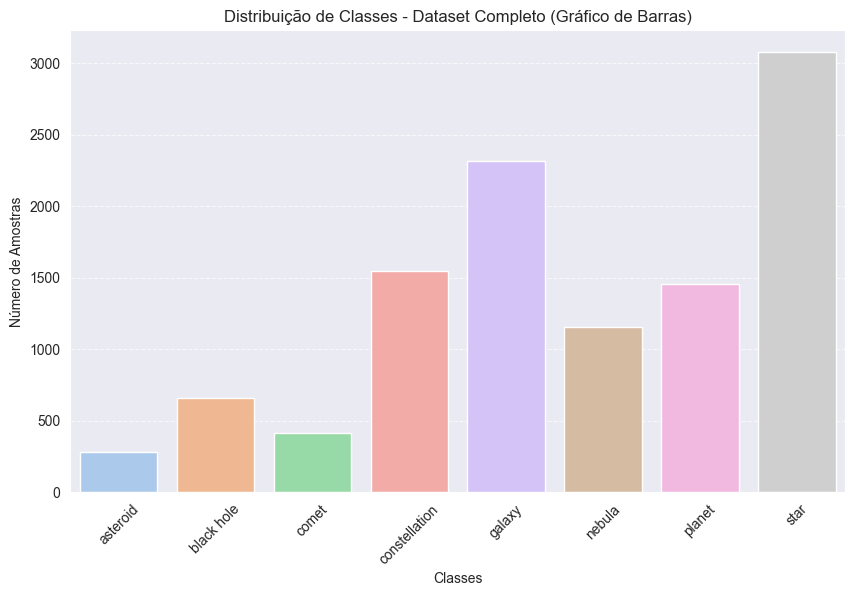

[INFO] Gerando gráfico de pizza para visualização...


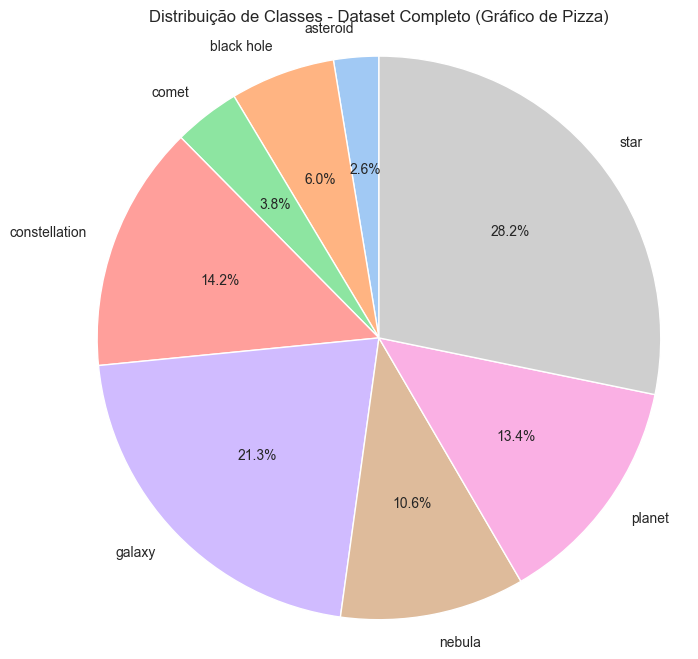

[INFO] Gráficos de distribuição gerados com sucesso.


In [14]:
def plot_class_distribution(dataset, dataset_type="Dataset Completo", title=None):
    """Visualizar a distribuição das classes e realizar análises extras."""
    
    if title is None:
        title = dataset_type

    print(f"[INFO] Iniciando a análise da distribuição das classes para: {title}")

    # Verificar se o dataset é um Subset (treino, validação, teste) ou um DatasetFolder completo
    if hasattr(dataset, 'dataset'):
        class_counts = collections.Counter([dataset.dataset.classes[label] for _, label in dataset])
    else:
        class_counts = collections.Counter([dataset.classes[label] for _, label in dataset.samples])
    
    total_samples = sum(class_counts.values())
    
    # Exibir o número total de amostras
    print(f"\n[INFO] Número total de amostras no {title}: {total_samples}")
    
    # Exibir estatísticas por classe
    print("[INFO] Exibindo a contagem por classe:")
    for class_name, count in class_counts.items():
        print(f"Classe '{class_name}': {count} amostras ({(count / total_samples) * 100:.2f}%)")
    
    # Identificar a classe mais e menos representada
    most_common_class = max(class_counts, key=class_counts.get)
    least_common_class = min(class_counts, key=class_counts.get)
    print(f"\n[INFO] Classe mais representada: {most_common_class} ({class_counts[most_common_class]} amostras)")
    print(f"[INFO] Classe menos representada: {least_common_class} ({class_counts[least_common_class]} amostras)")
    
    # Preparar dados para visualização
    class_names = list(class_counts.keys())
    class_values = list(class_counts.values())
    
    # Gráfico de Barras
    print("[INFO] Gerando gráfico de barras...")
    plt.figure(figsize=(10, 6))
    sns.barplot(x=class_names, y=class_values, palette="pastel")
    plt.title(f"Distribuição de Classes - {title} (Gráfico de Barras)")
    plt.xlabel("Classes")
    plt.ylabel("Número de Amostras")
    plt.xticks(rotation=45)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

    # Gráfico de Pizza
    print("[INFO] Gerando gráfico de pizza para visualização...")
    plt.figure(figsize=(8, 8))
    plt.pie(
        class_values, 
        labels=class_names, 
        autopct='%1.1f%%', 
        startangle=90, 
        colors=sns.color_palette('pastel')[0:len(class_counts)]
    )
    plt.title(f"Distribuição de Classes - {title} (Gráfico de Pizza)")
    plt.axis('equal')  # Assegurar que o gráfico seja um círculo
    plt.show()
    print("[INFO] Gráficos de distribuição gerados com sucesso.")

dataset = datasets.DatasetFolder(
    root=dataset_path,
    loader=lambda x: Image.open(x).convert('RGB'),
    extensions=("jpg", "jpeg", "png"),
    transform=transform
)
plot_class_distribution(dataset)

## 6. Preparar DataLoaders para Treinamento, Validação e Teste

### 6.1 Caregar o Dataset

In [15]:
def load_dataset(dataset_path):
    """Carregar o dataset usando pil_loader e transformações."""
    print("[INFO] Carregando o dataset...")

    dataset = datasets.DatasetFolder(
        root=dataset_path,
        loader=pil_loader,
        is_valid_file=is_valid_file,
        transform=transform
    )
    return dataset

# Exemplo de uso:
dataset = load_dataset("data/SpaceNet.FLARE.imam_alam")
print(f"[INFO] Total de amostras carregadas: {len(dataset.samples)}")

[INFO] Carregando o dataset...
[INFO] Total de amostras carregadas: 10898


### 6.2 Remover imagens corrompidas

In [16]:
def check_image_validity(path):
    """Verificar se uma imagem é válida usando pil_loader."""
    if is_valid_file(path):
        return pil_loader(path) is not None
    return False

def remove_corrupted_samples(dataset, max_threads=None):
    """Remover entradas inválidas (imagens corrompidas) usando processamento paralelo."""
    print("[INFO] Removendo entradas inválidas (imagens corrompidas)...")
    
    # Definir o número máximo de threads com base na CPU disponível
    if max_threads is None:
        max_threads = os.cpu_count()
    
    total_samples = len(dataset.samples)
    valid_samples = []

    # Processar em paralelo usando ThreadPoolExecutor
    with ThreadPoolExecutor(max_workers=max_threads) as executor:
        futures = {executor.submit(check_image_validity, path): (path, label) for path, label in dataset.samples}
        
        # Usar tqdm para barra de progresso
        with tqdm(total=total_samples, desc="Verificando amostras", unit="imagem") as pbar:
            for future in as_completed(futures):
                path, label = futures[future]
                try:
                    if future.result():  # Se a imagem for válida
                        valid_samples.append((path, label))
                except Exception as e:
                    print(f"[ERRO] Falha ao verificar a imagem: {path} - {e}")
                pbar.update(1)
    
    # Atualizar o dataset com as amostras válidas
    dataset.samples = valid_samples
    print(f"[INFO] Total de amostras válidas: {len(dataset.samples)}")
    return dataset

# Exemplo de uso:
dataset = remove_corrupted_samples(dataset)

[INFO] Removendo entradas inválidas (imagens corrompidas)...


Verificando amostras:  27%|██▋       | 2913/10898 [00:09<00:25, 312.17imagem/s]

[ERRO] Não foi possível carregar a imagem: data/SpaceNet.FLARE.imam_alam\constellation\constellation_page_9_image_7_aug3_SwinIR_large.jpeg - cannot identify image file <_io.BufferedReader name='data/SpaceNet.FLARE.imam_alam\\constellation\\constellation_page_9_image_7_aug3_SwinIR_large.jpeg'>
[ERRO] Não foi possível carregar a imagem: data/SpaceNet.FLARE.imam_alam\constellation\constellation_page_9_image_7_4_SwinIR_large.jpeg - image file is truncated (49 bytes not processed)
[ERRO] Não foi possível carregar a imagem: data/SpaceNet.FLARE.imam_alam\constellation\constellation_page_9_image_7_3_SwinIR_large.jpeg - image file is truncated (20 bytes not processed)
[ERRO] Não foi possível carregar a imagem: data/SpaceNet.FLARE.imam_alam\constellation\constellation_page_9_image_7_2_SwinIR_large.jpeg - image file is truncated (14 bytes not processed)


Verificando amostras: 100%|██████████| 10898/10898 [00:34<00:00, 315.03imagem/s]

[INFO] Total de amostras válidas: 10894


### 6.3 Dividir o dataset em treino, validação e teste

In [17]:
def split_dataset(dataset, val_split=0.2, test_split=0.1):
    """Dividir o dataset em treino, validação e teste."""
    print("[INFO] Dividindo o dataset em treino, validação e teste...")

    test_size = int(len(dataset) * test_split)
    val_size = int(len(dataset) * val_split)
    train_size = len(dataset) - test_size - val_size

    train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

    print(f"[INFO] Tamanho do conjunto de treino: {len(train_dataset)}")
    print(f"[INFO] Tamanho do conjunto de validação: {len(val_dataset)}")
    print(f"[INFO] Tamanho do conjunto de teste: {len(test_dataset)}")
    
    return train_dataset, val_dataset, test_dataset

# Exemplo de uso:
train_dataset, val_dataset, test_dataset = split_dataset(dataset)

[INFO] Dividindo o dataset em treino, validação e teste...
[INFO] Tamanho do conjunto de treino: 7627
[INFO] Tamanho do conjunto de validação: 2178
[INFO] Tamanho do conjunto de teste: 1089


### 6.4 Criar DataLoaders usando paralelismo

In [18]:
def create_dataloaders(train_dataset, val_dataset, test_dataset, batch_size=32):
    """Criar DataLoaders para treino, validação e teste."""
    print("[INFO] Criando DataLoaders...")

    max_threads = os.cpu_count()
    total_loaders = 3
    loaders = {}

    with ThreadPoolExecutor(max_workers=max_threads) as executor:
        futures = {
            'train_loader': executor.submit(DataLoader, train_dataset, batch_size=batch_size, shuffle=True, num_workers=max_threads, pin_memory=True),
            'val_loader': executor.submit(DataLoader, val_dataset, batch_size=batch_size, shuffle=False, num_workers=max_threads, pin_memory=True),
            'test_loader': executor.submit(DataLoader, test_dataset, batch_size=batch_size, shuffle=False, num_workers=max_threads, pin_memory=True)
        }

        with tqdm(total=total_loaders, desc="Carregando DataLoaders", unit="loader") as pbar:
            for future in as_completed(futures.values()):
                key = [k for k, v in futures.items() if v == future][0]
                loaders[key] = future.result()
                pbar.update(1)

    return loaders['train_loader'], loaders['val_loader'], loaders['test_loader']

# Exemplo de uso:
train_loader, val_loader, test_loader = create_dataloaders(train_dataset, val_dataset, test_dataset)

[INFO] Criando DataLoaders...


Carregando DataLoaders: 100%|██████████| 3/3 [00:00<?, ?loader/s]


### 6.5 Função para plotar a distribuição das classes de cada um dos datasets após a distribuição

In [19]:
def plot_class_distribution(dataset, title):
    """Visualizar a distribuição das classes."""
    print(f"[INFO] Iniciando a análise da distribuição das classes para: {title}")

    class_counts = collections.Counter([dataset.dataset.classes[label] for _, label in dataset])
    total_samples = sum(class_counts.values())
    
    print(f"[INFO] Número total de amostras no {title}: {total_samples}")
    
    # Gráfico de Barras
    class_names = list(class_counts.keys())
    class_values = list(class_counts.values())
    
    plt.figure(figsize=(10, 6))
    sns.barplot(x=class_names, y=class_values, palette="pastel")
    plt.title(f"Distribuição de Classes - {title} (Gráfico de Barras)")
    plt.xlabel("Classes")
    plt.ylabel("Número de Amostras")
    plt.xticks(rotation=45)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

### Dataset Treino

[INFO] Iniciando a análise da distribuição das classes para: Distribuição de Classes - Treino
[INFO] Número total de amostras no Distribuição de Classes - Treino: 7627


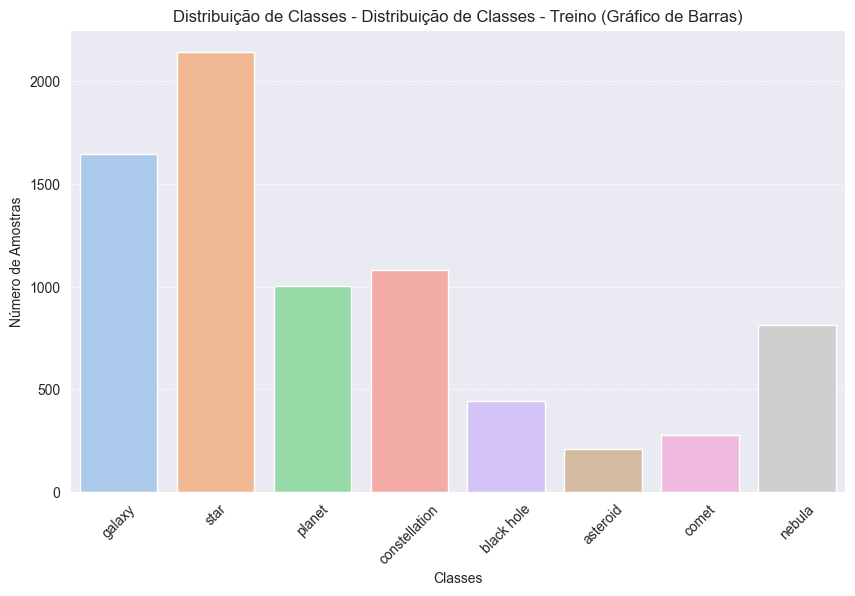

In [20]:
plot_class_distribution(train_dataset, "Distribuição de Classes - Treino")

### Dataset Validação

[INFO] Iniciando a análise da distribuição das classes para: Distribuição de Classes - Validação
[INFO] Número total de amostras no Distribuição de Classes - Validação: 2178


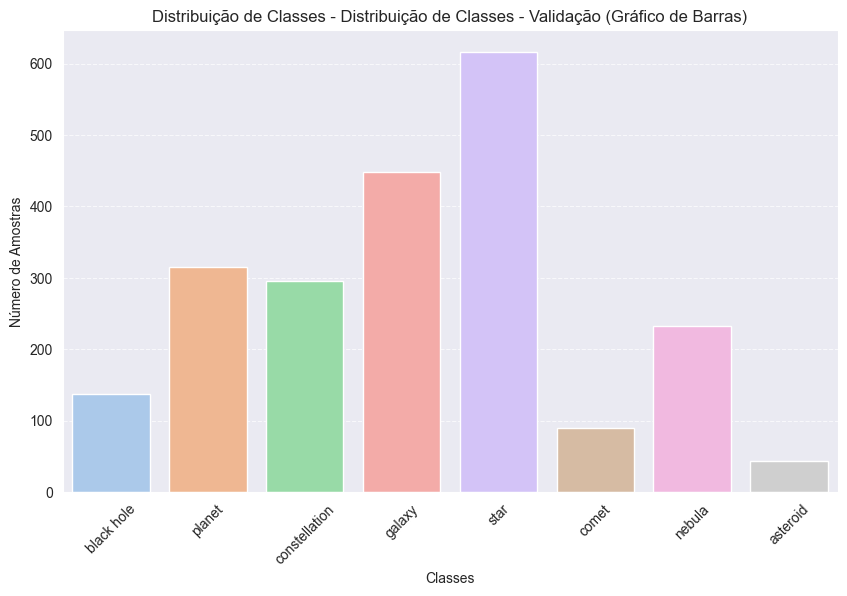

In [21]:
plot_class_distribution(val_dataset, "Distribuição de Classes - Validação")

### Dataset Teste

[INFO] Iniciando a análise da distribuição das classes para: Distribuição de Classes - Teste
[INFO] Número total de amostras no Distribuição de Classes - Teste: 1089


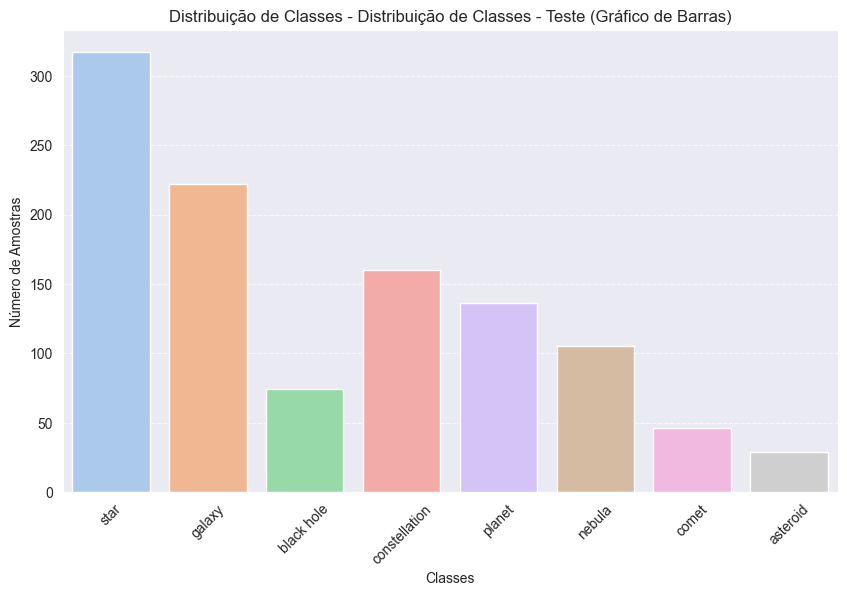

In [22]:
plot_class_distribution(test_dataset, "Distribuição de Classes - Teste")

## Validar o uso de CUDA em um batch de treino

In [23]:
def process_batch(images, labels, device):
    """Função para mover o batch para o dispositivo e retornar o resultado."""
    images = images.to(device, non_blocking=True)
    labels = labels.to(device, non_blocking=True)
    return images, labels

### Função para carregar e processar batches em paralelo

In [24]:
def load_batches_in_parallel(data_loader, device, max_workers=os.cpu_count()):
    with ThreadPoolExecutor(max_workers=max_workers) as executor:
        futures = [
            executor.submit(process_batch, images, labels, device)
            for images, labels in data_loader
        ]
        
        # Utilizar tqdm para exibir progresso
        with tqdm(total=len(futures), desc="Carregando batches", unit="batch") as pbar:
            for future in as_completed(futures):
                images, labels = future.result()
                print(f"[INFO] Batch carregado: {len(images)} imagens no dispositivo {device}")
                pbar.update(1)
                break  # Para carregar apenas um batch como no exemplo original

### Configuração do dispositivo (GPU ou CPU)

In [25]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"[INFO] Utilizando dispositivo: {device}")

[INFO] Utilizando dispositivo: cuda


### Carregar o DataLoader


In [ ]:
load_batches_in_parallel(train_loader, device)

## Criar o Modelo de Rede Neural

Usamos uma arquitetura ResNet18 pré-treinada para classificar as imagens.


In [ ]:
def create_model(hidden_units=512, dropout_rate=0.4):
    print("[INFO] Criando o modelo ResNet18...")
    model = models.resnet18(weights='IMAGENET1K_V1')
    num_ftrs = model.fc.in_features
    model.fc = nn.Sequential(
        nn.Linear(num_ftrs, hidden_units),
        nn.ReLU(),
        nn.Dropout(dropout_rate),
        nn.Linear(hidden_units, 2)
    )
    return model.to(device)

model = create_model()
print("[INFO] Modelo criado com sucesso.")

## Treinar o Modelo com Early Stopping

Nesta seção, treinamos o modelo utilizando o método de Early Stopping para evitar overfitting.


In [ ]:
torch.backends.cudnn.benchmark = True  # Acelerar operações em GPU se o tamanho das entradas for constante

def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10):
    print("[INFO] Iniciando o treinamento do modelo...")
    best_val_loss = float('inf')
    patience_counter = 0
    early_stopping_patience = 5

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0

        # Usar múltiplos workers para carregamento paralelo
        for images, labels in tqdm(train_loader, desc=f"Época {epoch + 1}/{num_epochs}"):
            images, labels = images.to(device, non_blocking=True), labels.to(device, non_blocking=True)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        val_loss = validate_model(model, val_loader, criterion)
        print(f"[INFO] Época {epoch + 1}, Perda de Validação: {val_loss:.4f}")
        
        # Early Stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= early_stopping_patience:
                print("[INFO] Early stopping ativado.")
                break

# Configurar DataLoaders com paralelismo
train_loader = DataLoader(train_loader, batch_size=32, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4, pin_memory=True)

# Definir critério e otimizador
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Treinar o modelo
train_model(model, train_loader, val_loader, criterion, optimizer)

## Função de Validação do Modelo

Essa função calcula a perda de validação para o Early Stopping.


In [ ]:
def validate_model(model, val_loader, criterion):
    print("[INFO] Validando o modelo...")
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
    return val_loss / len(val_loader)

## Avaliar o Modelo com o Conjunto de Teste

Nesta célula, usamos o conjunto de teste para avaliar a precisão do modelo e plotamos a matriz de confusão.


In [ ]:
def evaluate_model(model, test_loader):
    print("[INFO] Avaliação final do modelo...")
    y_true, y_pred = [], []
    model.eval()
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

    conf_matrix = confusion_matrix(y_true, y_pred)
    sns.heatmap(conf_matrix, annot=True, cmap="Blues")
    plt.xlabel("Predito")
    plt.ylabel("Verdadeiro")
    plt.show()

    report = classification_report(y_true, y_pred)
    print("\nRelatório de Classificação:\n", report)

evaluate_model(model, test_loader)

## Função de Otimização de Hiperparâmetros com Optuna

Definimos a função de otimização para ajustar os parâmetros usando o Optuna.


In [ ]:
def objective(trial):
    print(f"[INFO] Iniciando o trial {trial.number} para otimização...")

    # Obter os DataLoaders
    train_loader, val_loader, _ = get_data_loaders(dataset_path)

    # Sugerir valores para os hiperparâmetros
    hidden_units = trial.suggest_int("hidden_units", 256, 1024, step=256)
    dropout_rate = trial.suggest_float("dropout_rate", 0.3, 0.5)
    learning_rate = trial.suggest_float("learning_rate", 1e-5, 1e-3, log=True)

    # Criar o modelo com os hiperparâmetros sugeridos
    model = create_model(hidden_units, dropout_rate)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # Treinar o modelo
    train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=5)

    # Validar o modelo e obter a perda de validação
    val_loss = validate_model(model, val_loader, criterion)
    return val_loss

## Executar Otimização de Hiperparâmetros

Executamos o processo de otimização e encontramos os melhores parâmetros.


In [ ]:
def run_optuna_optimization():
    print("[INFO] Iniciando otimização com Optuna...")
    study = optuna.create_study(direction="minimize")
    study.optimize(objective, n_trials=5)

    # Exibir os melhores hiperparâmetros encontrados
    print("[INFO] Melhores hiperparâmetros encontrados:", study.best_params)
    return study.best_params

# Executar a otimização
best_params = run_optuna_optimization()